# __Network in Network - MXNet__

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

In [2]:
def transform(image):
    image = image.astype('float32')/255.0
    image = mx.image.imresize(image, 84, 84)
    return image.transpose((2, 0, 1))

train_mnist = gluon.data.vision.CIFAR10(train = True).transform_first(transform)
test_mnist = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [3]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(3, 84, 84)
9


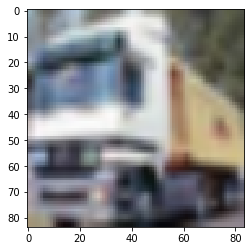

In [4]:
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.show()

## __Defining data loaders__

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining Network in Network Model Architecture__

In [6]:
def ninblock(channels):
    block = nn.HybridSequential()
    block.add(nn.Conv2D(channels, kernel_size = 1, activation = 'relu'))
    block.add(nn.Conv2D(channels, kernel_size = 1, activation = 'relu'))
    block.add(nn.BatchNorm())
    # batchnorm is originally the part of nin blocks, but we are adding it inorder to speed up the training
    return block

In [7]:
model = nn.HybridSequential()

model.add(nn.Conv2D(channels = 96, kernel_size = (11, 11), strides = (4, 4)))
model.add(ninblock(96))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Conv2D(channels = 256, kernel_size = (5, 5), padding = (2, 2)))
model.add(ninblock(256))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Conv2D(channels = 384, kernel_size = (3, 3), padding = (1, 1)))
model.add(ninblock(384))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Dropout(0.5))

model.add(nn.Conv2D(channels = 10, kernel_size = (3, 3), padding = (1, 1)))
model.add(ninblock(10)) # total 10 channels in this layer
model.add(nn.GlobalAvgPool2D()) # this calculates sum for each channels in last layer

model.add(nn.Flatten()) # so this is the output layer with shape (-1, 10)

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 96, kernel_size=(11, 11), stride=(4, 4))
  (1): HybridSequential(
    (0): Conv2D(None -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
    (1): Conv2D(None -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  )
  (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): Conv2D(None -> 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): HybridSequential(
    (0): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
    (1): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  )
  (5): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max

## __Summarizing the model__

In [8]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 84, 84)               0
            Conv2D-1                             (1, 96, 19, 19)           34944
        Activation-2                     <Symbol conv1_relu_fwd>               0
        Activation-3                             (1, 96, 19, 19)               0
            Conv2D-4                             (1, 96, 19, 19)            9312
        Activation-5                     <Symbol conv2_relu_fwd>               0
        Activation-6                             (1, 96, 19, 19)               0
            Conv2D-7                             (1, 96, 19, 19)            9312
         BatchNorm-8                             (1, 96, 19, 19)             384
         MaxPool2D-9                               (1, 96, 9, 9)               0
           Conv2D-10        

## __Visualizing model architecture__

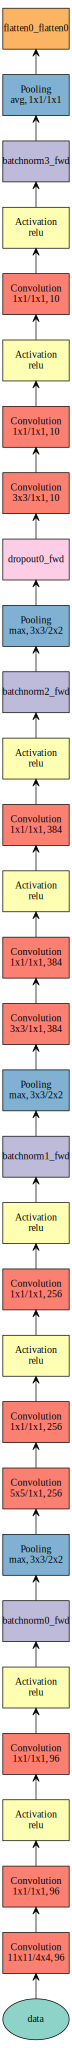

In [9]:
mx.viz.plot_network(model(mx.sym.var(name = 'data', shape = (1, 1, 224, 224))))

By hybridizing the model becomes almost 1.5x fast, as it converts dynamically defined model in to static graph. Its a really cool feature that MXNet provides

In [10]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [13]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})
# network in network models takes slightly larger learning rate

## __Training the model__

In [14]:
epochs = 5
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 1.87744 | Training Accuracy: 0.29116
Epoch: 2 | Loss: 1.57286 | Training Accuracy: 0.41684
Epoch: 3 | Loss: 1.35108 | Training Accuracy: 0.51464
Epoch: 4 | Loss: 1.23482 | Training Accuracy: 0.55848
Epoch: 5 | Loss: 1.13193 | Training Accuracy: 0.59650


## __Testing the model__

In [15]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.6107)